# Framework

- Data - Palbociclib Data (Proteomics and GDSC2)
- Preprocessing method - missing data imputation by lower quantile (0 to 0.25)
- Feature selection (Filtering) - select features with pearson correlation >= |0.4|
- Model - Elastic Net
- Target variable used - AUC

## Initialisation

In [ ]:
import os 
import DataFunctions as utils
import Visualisation as vis
from toolkit import * 
import numpy as np
import pandas as pd

: 

In [19]:
### Load data

import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open('data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)

# import CCLE gene expression data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

# import CCLE sample info data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)


# import proteomic expression
with open('data/proteomic-expression/goncalves-2022-cell/goncalve_proteome_fillna_processed.pkl', 'rb') as f:
    joined_full_protein_matrix = pickle.load(f)
    joined_sin_peptile_exclusion_matrix = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# open STRING to goncalves mapping file

with open('data\protein-interaction\STRING\goncalve_to_string_id_df.pkl', 'rb') as f:
    goncalve_to_string_id_df = pickle.load(f)

# open the cache for neighbourhood calculations

with open('data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl', 'rb') as f:
    nth_degree_neighbours = pickle.load(f)


In [27]:
### Config Parameters

## Data 

# create the full dataset
drug_selected = 'Palbociclib'

## Preprocessing Method
# Between fill by zero, impute by random variable between 0 to 1st quantile
# Impute1stQuantile, Fill0, ImputeKNN
preprocessing_method = 'Impute1stQuantile'

# set threshold for feature removal (0.8 means remove features with > 80% missing values)
feature_nan_removal_threshold = 0.8

## Feature Selection Methods

## Models 
## Target variable used

target_variable = 'AUC'

## Hyperparameters
experiment_name = 'test'
save_input = True
save_output = True

# hyperparameters
max_gene_target_disance = 2 # specify the level of biological relevance to drug target(s)
statistical_filter_size = 100 # can be optimized using global feature dropout testing
monte_carlo_cross_validation_size = 50 # can be automatically optimized via rank impact assessment
models_used = ['RandomForestRegressor']
models_hyperparameters = [{},]

# extra hyperparameters
statistical_filter_threshold = 0.05 # currently not in use
cv_split_size = 0.1
n_cores_to_use = -1 # global parameter for parallel processing, -1 means all cores

# generated hyperparameters
rng_seed_lists = []
for j in range(monte_carlo_cross_validation_size):
    rng_seed_lists.append(np.random.randint(100000))


verbose = True
max_feature_save_size = 1000
data_collector = []
conditions_to_test = ['network_f_regression_selection',]
conditions_to_get_feature_importance = [True,]
matched_functions = [get_network_stat_features,]
extra_args = [(nth_degree_neighbours, max_gene_target_disance, statistical_filter_size),]
features_to_knockout = []

save_results_path = 'data//results//workbook-4-jun-rf' 

if not os.path.exists(save_results_path):
    os.makedirs(save_results_path)

## Custom Functions

def impute_with_random_selection(X_train, y_train, X_test, n_features):
    X_train, y_train, X_test = impute_by_first_quantile(X_train, y_train, X_test)
    features, X_train, X_test = get_random_features(X_train, y_train, X_test, n_features)
    return features, X_train, X_test

def impute_with_stat_selection(X_train, y_train, X_test, statistical_filter_size):
    X_train, y_train, X_test = impute_by_first_quantile(X_train, y_train, X_test)
    # perform feature selection on the training set
    selector = SelectKBest(f_regression, k=statistical_filter_size)
    selector.fit(X_train, y_train)
    # get the selected features
    selected_features = X_train.columns[selector.get_support()]
    sel_train, sel_test = X_train[selected_features], X_test[selected_features]
    return selected_features, sel_train, sel_test

def impute_with_network_stat_selection(X_train, y_train, X_test, nth_degree_neighbours, max_gene_target_disance, statistical_filter_size):
    X_train, y_train, X_test = impute_by_first_quantile(X_train, y_train, X_test)
    features, sel_train, sel_test = get_network_stat_features(X_train, y_train, X_test, nth_degree_neighbours, max_gene_target_disance, statistical_filter_size)
    return features, sel_train, sel_test

In [28]:
data_df = utils.create_joint_dataset_from_proteome_gdsc(drug_selected, joined_sin_peptile_exclusion_matrix, gdsc2, drug_value=target_variable)
feature_data, label_data = utils.create_feature_and_label(data_df, label_name=target_variable)

## Run Feature Size Tests

In [29]:
## Test Feature Size Effect on training performance between 0 to 500 

feature_size_tested = []
for i in range(1, 500, 10):
    feature_size_tested.append(i)

all_df = pd.DataFrame()

for feature_size in feature_size_tested:
    print(f'------------------ feature size: {feature_size}')
    feature_size_df = run_bulk_test(['random', 'stat', 'network_stat'], 
                                    [False, False, False], 
                                    [impute_with_random_selection, impute_with_stat_selection, impute_with_network_stat_selection], 
                                    [(feature_size,), (feature_size,), (nth_degree_neighbours, max_gene_target_disance, feature_size)],
                                    models_used, models_hyperparameters,
                                    rng_seed_lists, 
                                    feature_data, label_data,
                                    cv_split_size=cv_split_size, 
                                    verbose=False, 
                                    bulk_run_tag=f'feature_size_{feature_size}',
                                    save_output=False,
                                    n_jobs=n_cores_to_use
                                    )
    # create a column for feature size for each row
    feature_size_df['feature_size'] = feature_size
    all_df = pd.concat([all_df, feature_size_df], axis=0)

------------------ feature size: 1
------------------ feature size: 11
------------------ feature size: 21
------------------ feature size: 31
------------------ feature size: 41
------------------ feature size: 51
------------------ feature size: 61
------------------ feature size: 71
------------------ feature size: 81
------------------ feature size: 91
------------------ feature size: 101
------------------ feature size: 111
------------------ feature size: 121
------------------ feature size: 131
------------------ feature size: 141
------------------ feature size: 151
------------------ feature size: 161
------------------ feature size: 171
------------------ feature size: 181
------------------ feature size: 191
------------------ feature size: 201
------------------ feature size: 211
------------------ feature size: 221
------------------ feature size: 231
------------------ feature size: 241
------------------ feature size: 251
------------------ feature size: 261
------------

In [30]:
all_df.shape

(7500, 14)

In [31]:
all_df.reset_index(drop=True, inplace=True)

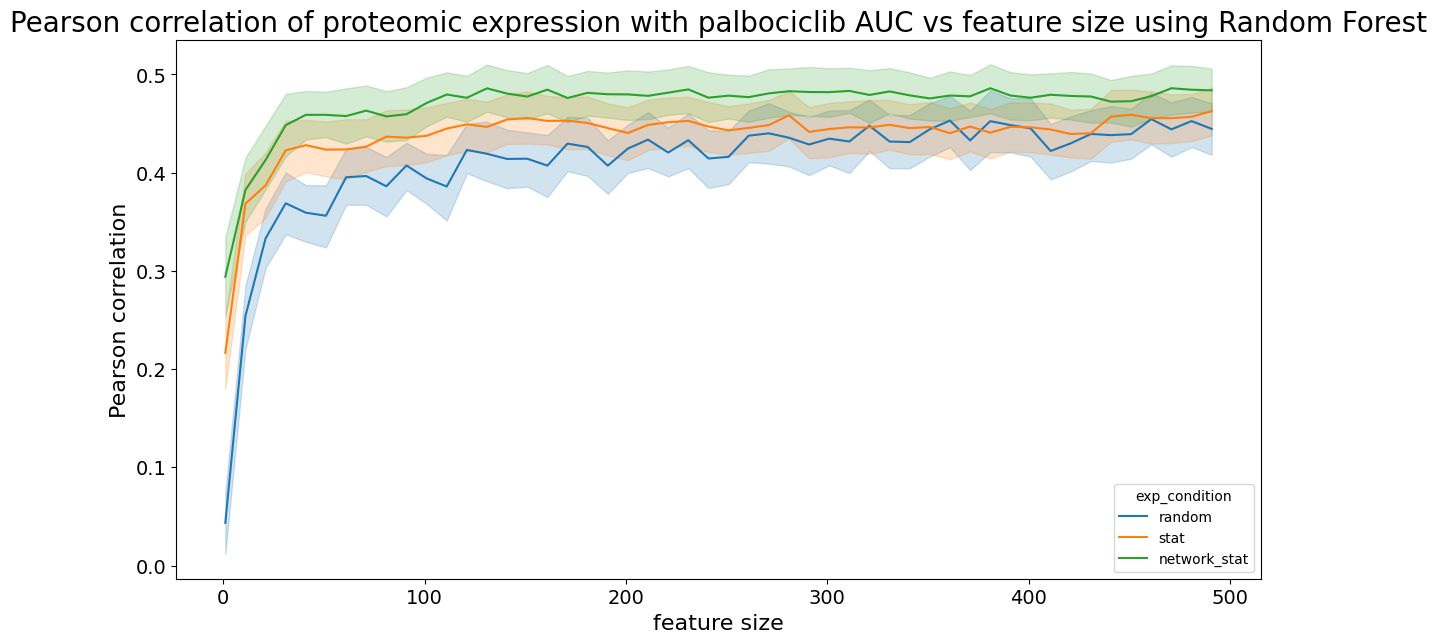

In [32]:
### plot the results

import seaborn as sns

# plot a line plot with error bars for pearson correlation

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x='feature_size', y='corr', hue='exp_condition', data=all_df, ax=ax)
ax.set_title(f'Pearson correlation of proteomic expression with palbociclib AUC vs feature size using Random Forest')
ax.set_xlabel('feature size')
ax.set_ylabel('Pearson correlation')
# enlarge the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# enlarge the xlabel and ylabel
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# enlarge the title
ax.title.set_fontsize(20)
plt.savefig(save_results_path+'feature_size_pearson_corr.png', dpi=300, bbox_inches='tight')
plt.show()

## Run consensus SHAP tests

In [33]:
### Record SHAP values for network stat features

shap_df = run_bulk_test(['network_stat'],
                        [True],
                        [impute_with_network_stat_selection],
                        [(nth_degree_neighbours, max_gene_target_disance, statistical_filter_size)],
                        models_used, models_hyperparameters,
                        rng_seed_lists,
                        feature_data, label_data,
                        cv_split_size=cv_split_size,
                        verbose=False,
                        bulk_run_tag=f'feature_selection_shap',
                        save_output=False,
                        output_file_path=save_results_path+'/shap_output.pkl',
                        n_jobs=n_cores_to_use
                        )


shap_contribs = get_mean_contribution(shap_df, 'network_stat')



### Plotting mean contribution


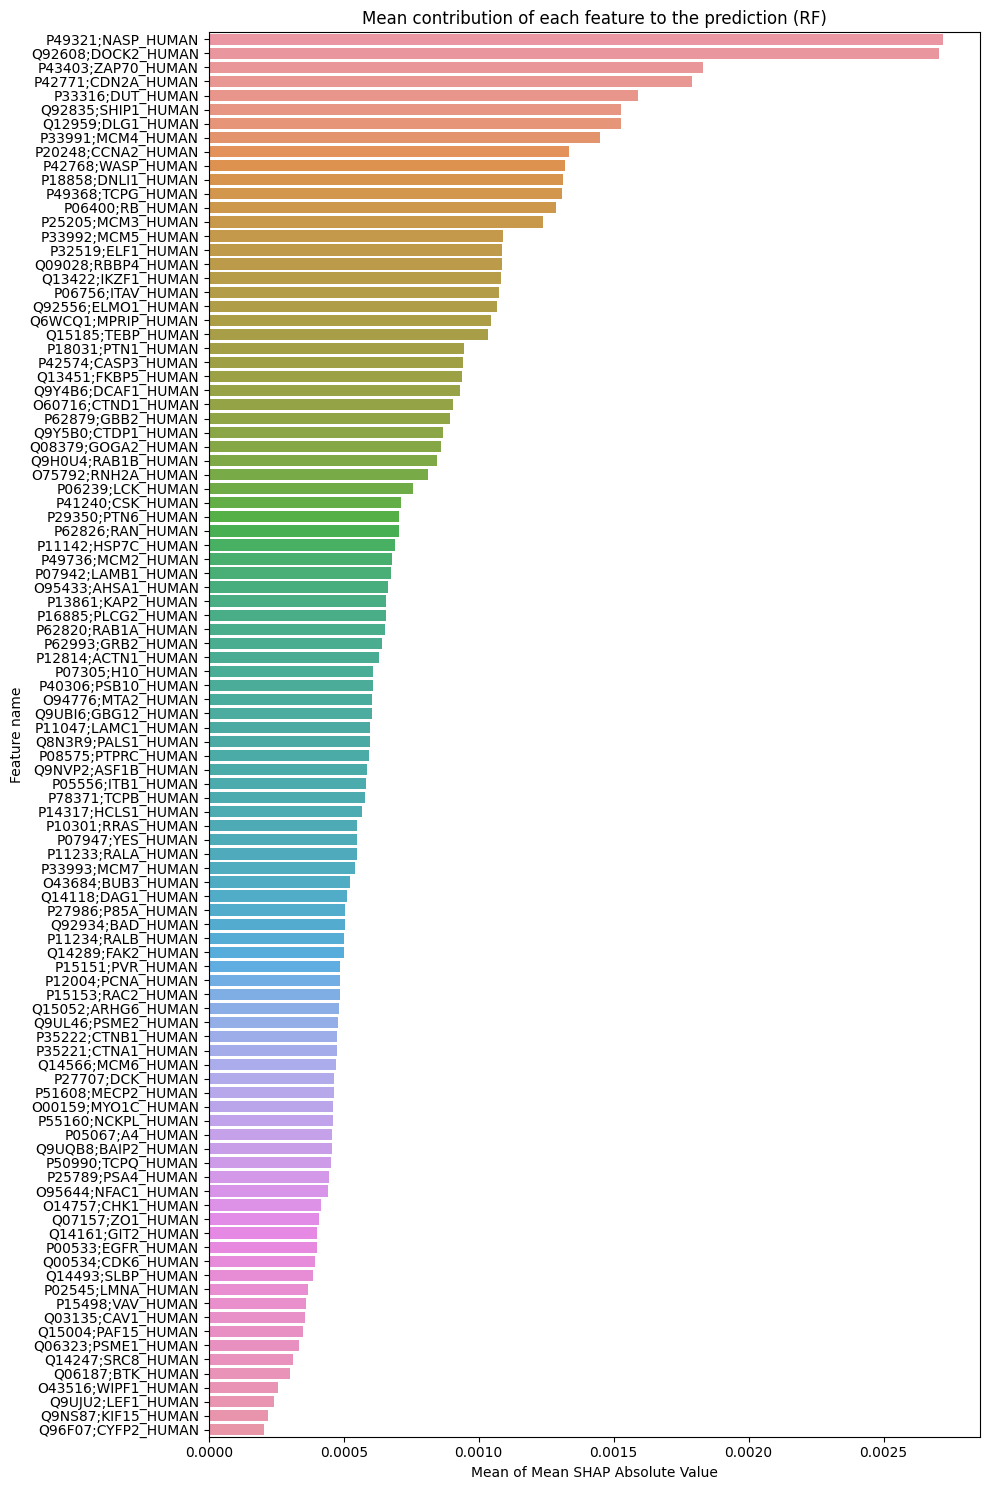

In [34]:
# plot the mean shap values

import matplotlib.pyplot as plt
import seaborn as sns

print('### Plotting mean contribution')
plt.figure(figsize=(10, 15))
sns.barplot(x=shap_contribs.values, y=shap_contribs.index)
plt.title('Mean contribution of each feature to the prediction (RF)')
plt.xlabel('Mean of Mean SHAP Absolute Value')
plt.ylabel('Feature name')
plt.tight_layout()
plt.savefig(save_results_path+'/mean_contribution.png', dpi=300)
plt.show()